In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import gc

In [765]:
def get_best_features(data, labels, fnames, num_plots=3):
    roc_arr = []
    pos = (labels == 1).sum()
    neg = (labels == 0).sum()
    for j in range(data.shape[1]):
        vals = np.unique(data[:, j])
        ths = np.pad((vals[:-1] + vals[1:])/2, (1, 1), mode='constant', 
                     constant_values=(vals[0], vals[-1]+0.0001))
        tpr_fpr = np.zeros([ths.shape[0], 2])
        for i, t in enumerate(ths):
            preds = data[:, j] >= t
            tpr_fpr[i, 1] = np.logical_and(labels == 0, preds).sum()/neg
            tpr_fpr[i, 0] = np.logical_and(labels, preds).sum()/pos   
        tpr_fpr = tpr_fpr[tpr_fpr[:, 0].argsort(kind='mergesort')]
        roc_auc = np.trapz(y=tpr_fpr[:, 0], x=tpr_fpr[:, 1])
        if (roc_auc < 0.5):
            tpr_fpr = tpr_fpr[:, [1, 0]]
            roc_auc = np.trapz(y=tpr_fpr[:, 0], x=tpr_fpr[:, 1])
        roc_arr.append([roc_auc, tpr_fpr, j])
    roc_arr = sorted(roc_arr, key=lambda x: x[0], reverse=True)
    fig, axarr = plt.subplots(1, num_plots, figsize = [16, 7])
    fig.suptitle(f'{num_plots} best features by ROC AUC')
    for i in range(num_plots):
        axarr[i].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
        axarr[i].plot(roc_arr[i][1][:, 1], roc_arr[i][1][:, 0], 
                      label=f'ROC AUC = {round(roc_arr[i][0], 3)}\nFeature: {fnames[roc_arr[i][2]]}')
        axarr[i].legend(loc=4)
        axarr[i].grid()
        axarr[i].set_xlabel('FPR')
        axarr[i].set_ylabel('TPR')

def my_accuracy(labels, preds):
    return (labels == preds).sum()/len(labels)

def get_unique_models(acc_arr):
    acc_dic = {}
    for acc, model in acc_arr:
        if acc not in acc_dic.keys():
            acc_dic[acc] = model
        elif acc_dic[acc].max_depth > model.max_depth:
            acc_dic[acc] = model
    return acc_dic

In [748]:
from sklearn.base import BaseEstimator

#IMPURITIES:

def gini(labels):
    p = np.bincount(labels)/len(labels)
    return np.dot(p, 1-p)

def entropy(labels):
    p = np.bincount(labels)/len(labels)
    return -np.dot(p, np.log2(p))

def misclass_err(labels):
    p = np.bincount(labels)/len(labels)
    try:
        return 1 - max(p)
    except:
        return 0

class Node:
    
    data = None
    labels = None
    
    def __init__(self, indices, max_depth, parent=None):
        
        self.max_depth = max_depth
        if parent == None:
            self.depth = 0
        else:
            self.depth = parent.depth + 1
        
        if self.depth >= self.max_depth:
            self.is_leaf = True
        else:
            self.is_leaf = False
        
        self.indices = indices  
            
    def extend(self, stack, impurity):
        
        labs = self.labels[self.indices]
        
        if self.is_leaf:
            try:
                self.prob = (np.bincount(labs)/len(labs))[1]
            except:
                self.prob = 0
            return 
        
        data_set = self.data[self.indices, :]
        
        max_gain = np.NINF
        best_j = None
        best_t = None
        best_lind = None
        best_rind = None
        
        for j in range(data_set.shape[1]):
            vals = np.unique(data_set[:, j])
            ths = np.pad((vals[:-1] + vals[1:])/2, (1, 1), mode='constant', 
                         constant_values=(vals[0], vals[-1]+0.0001))
            for t in ths:
                node_imp = (data_set.shape[0]/self.data.shape[0])*impurity(labs)
                rind = np.logical_and(self.indices, self.data[:, j] >= t)
                right_imp = (rind.sum()/self.data.shape[0])*impurity(self.labels[rind])
                lind = np.logical_and(self.indices, self.data[:, j] < t)
                left_imp = (lind.sum()/self.data.shape[0])*impurity(self.labels[lind])
                gain = node_imp - (right_imp + left_imp)
                assert(np.logical_xor(rind, lind).sum() == data_set.shape[0])
                if gain > max_gain:
                    max_gain = gain
                    best_j = j
                    best_t = t
                    best_lind = lind
                    best_rind = rind
                    
        if max_gain > 0:
            self.feature = best_j
            self.threshold = best_t
            self.left_child = Node(best_lind, self.max_depth, self)
            self.right_child = Node(best_rind, self.max_depth, self) 
            stack.append(self.left_child)
            stack.append(self.right_child)
        else:
            self.is_leaf = True
            try:
                self.prob = (np.bincount(labs)/len(labs))[1]
            except:
                self.prob = 0
    
    def decide(self, example):
        if self.is_leaf:
            return self.prob
        else:
            if example[self.feature] >= self.threshold:
                return self.right_child
            else:
                return self.left_child

class Decision_Tree(BaseEstimator):
    
    def __init__(self, impurity, max_depth=5):
        self.impurity = impurity
        self.max_depth = max_depth
        Node.data = None
        Node.labels = None
        
    def __del__(self):
        Node.data = None
        Node.labels = None
    
    def fit(self, data_set, labels):
        Node.data = data_set
        Node.labels = labels
        self.root = Node(np.full(data_set.shape[0], True), max_depth=self.max_depth)
        self.NodeStack = [self.root]
        while self.NodeStack:
            curr = self.NodeStack.pop()
            curr.extend(self.NodeStack, self.impurity)
            
    def predict_proba(self, data):
        probas = np.zeros([data.shape[0], 2])
        for i, x in enumerate(data):
            curr = self.root
            while not curr.is_leaf:
                curr = curr.decide(x)
            p = curr.decide(x)
            probas[i, :] = [1 - p, p]
        return probas
    
    def predict(self, data):
        probas = self.predict_proba(data)
        preds = probas[:, 1] > 0.5
        return preds

## Cancer data:

In [301]:
df_cancer = pd.read_csv('Data/cancer.csv')
df_cancer['label'], enc = pd.factorize(df_cancer['label'])
print(enc)
df_cancer.head()

Index(['M', 'B'], dtype='object')


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [305]:
num_data_canc = df_cancer.drop(columns='label').values
labels_canc = df_cancer['label'].values

### Three best features for making a decision rule:

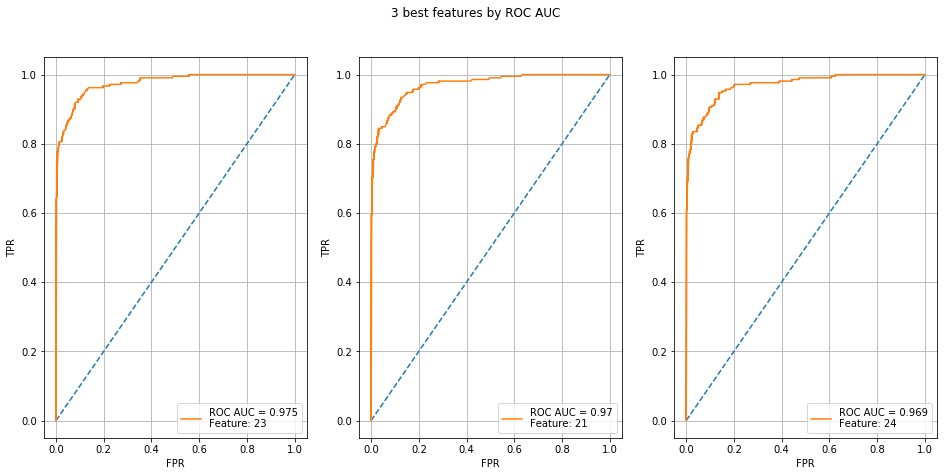

In [694]:
get_best_features(num_data_canc, labels_canc, fnames=df_cancer.columns[1:], num_plots=3)

### Train-validate split:

In [696]:
print('Initial proportions: \n', df_cancer['label'].value_counts(normalize=True), sep='')
X_tc, X_vc, y_tc, y_vc = train_test_split(num_data_canc, labels_canc, test_size=0.2,
                                     shuffle=True, stratify=labels_canc)
tu, tc = np.unique(y_t, return_counts=True)
print('Proportions after splitting: \n', 'Train: \n', np.vstack((tu, tc/tc.sum())).T, sep='')
vu, vc = np.unique(y_v, return_counts=True)
print('Validate: \n', np.vstack((vu, vc/vc.sum())).T, sep='')

Initial proportions: 
1    0.627417
0    0.372583
Name: label, dtype: float64
Proportions after splitting: 
Train: 
[[ 0.          0.37362637]
 [ 1.          0.62637363]]
Validate: 
[[ 0.          0.36842105]
 [ 1.          0.63157895]]


### Choosing best trees according to accuracy:

In [749]:
import warnings
from itertools import product
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')
acc_arr = []
for depth, impurity in tqdm_notebook(product(range(1, 11), [gini, entropy, misclass_err])):
    model = Decision_Tree(impurity, max_depth=depth)
    model.fit(X_tc, y_tc)
    preds = model.predict(X_vc)
    acc_arr.append((my_accuracy(y_vc, preds), model))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [769]:
top_c = get_unique_models(acc_arr)
top_c = [(k, top_c[k]) for k in sorted(top_c, reverse=True)]
print('Best parameters: ')
for i, tup in enumerate(top_c):
    print(f'MaxDepth = {tup[1].max_depth};', 
          f'Impurity: {tup[1].impurity.__name__}', 
          f'Accuracy = {round(tup[0], 10)}')
    if i == 2: break

Best parameters: 
MaxDepth = 4; Impurity: gini Accuracy = 0.9649122807
MaxDepth = 4; Impurity: entropy Accuracy = 0.9561403509
MaxDepth = 5; Impurity: entropy Accuracy = 0.9385964912


### Building ROCs for best models:

In [812]:
def top_rocs(top, test, labels):
    probas_arr = [model.predict_proba(test) for _, model in top]
    fig, axarr = plt.subplots(1, 3, figsize=[16, 7])
    fig.suptitle('ROC curves:')
    for i, ax in enumerate(axarr):
        fpr, tpr, score = my_roc_curve(labels, probas_arr[i][:, 1])
        ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
        ax.plot(fpr, tpr,
               label='ROC AUC = {}\nMax Depth = {}\nImpurity: {}'\
               .format(round(score, 3), top[i][1].max_depth, top[i][1].impurity.__name__))
        ax.legend(loc=4)
        ax.grid()
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        
def my_roc_curve(labels, preds):
    vals = np.unique(preds)
    ths = np.pad((vals[:-1] + vals[1:])/2, (1, 1), mode='constant', 
                    constant_values=(vals[0], vals[-1]+0.0001))
    tpr_fpr = np.zeros([ths.shape[0]+1, 2])
    for i, t in enumerate(ths):
        p = preds >= t
        tpr_fpr[i, 0] = np.logical_and(labels == 1, p).sum()/(labels == 1).sum()
        tpr_fpr[i, 1] = np.logical_and(labels == 0, p).sum()/(labels == 0).sum()
    tpr_fpr = tpr_fpr[tpr_fpr[:, 0].argsort(kind='mergesort')]
    roc_auc = np.trapz(y=tpr_fpr[:, 0], x=tpr_fpr[:, 1])
    return tpr_fpr[:, 1], tpr_fpr[:, 0], roc_auc

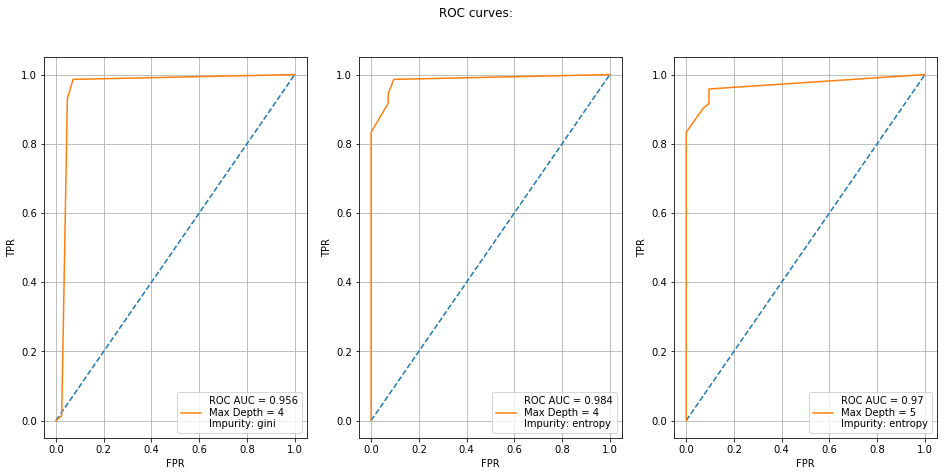

In [813]:
top_rocs(top_c, X_vc, y_vc)

## Spam data:

In [175]:
df_spam = pd.read_csv('Data/spam.csv')
df_spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [187]:
num_data_spam = df_spam.drop(columns='label').values
labels_spam = df_spam['label'].values

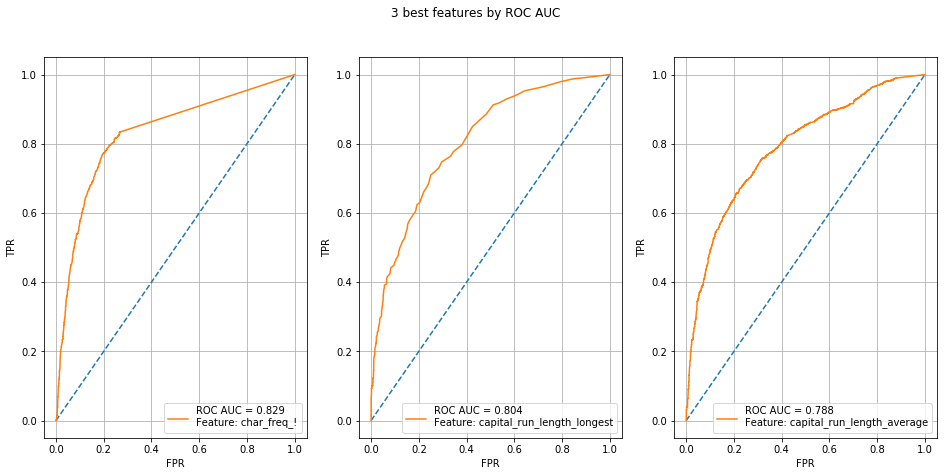

In [695]:
get_best_features(num_data_spam, labels_spam, fnames=df_spam.columns[:-1])

### Train-validate split:

In [814]:
print('Initial proportions: \n', df_spam['label'].value_counts(normalize=True), sep='')
X_ts, X_vs, y_ts, y_vs = train_test_split(num_data_spam, labels_spam, test_size=0.2,
                                     shuffle=True, stratify=labels_spam)
tu, tc = np.unique(y_ts, return_counts=True)
print('Proportions after splitting: \n', 'Train: \n', np.vstack((tu, tc/tc.sum())).T, sep='')
vu, vc = np.unique(y_vs, return_counts=True)
print('Validate: \n', np.vstack((vu, vc/vc.sum())).T, sep='')

Initial proportions: 
0    0.605955
1    0.394045
Name: label, dtype: float64
Proportions after splitting: 
Train: 
[[ 0.          0.60597826]
 [ 1.          0.39402174]]
Validate: 
[[ 0.          0.60586319]
 [ 1.          0.39413681]]


### Choosing best trees according to accuracy:

In [815]:
acc_arrs = []
for depth, impurity in tqdm_notebook(product(range(1, 11), [gini, entropy, misclass_err])):
    model = Decision_Tree(impurity, max_depth=depth)
    model.fit(X_ts, y_ts)
    preds = model.predict(X_vs)
    acc_arrs.append((my_accuracy(y_vs, preds), model))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [828]:
top_s = get_unique_models(acc_arrs)
top_s = [(k, top_s[k]) for k in sorted(top_s, reverse=True)]
print('Best parameters: ')
for i, tup in enumerate(top_s):
    print(f'MaxDepth = {tup[1].max_depth};', 
          f'Impurity: {tup[1].impurity.__name__}', 
          f'Accuracy = {round(tup[0], 10)}')
    if i == 2: break

Best parameters: 
MaxDepth = 9; Impurity: entropy Accuracy = 0.9239956569
MaxDepth = 10; Impurity: gini Accuracy = 0.9218241042
MaxDepth = 7; Impurity: entropy Accuracy = 0.9207383279


### Building ROCs for best models:

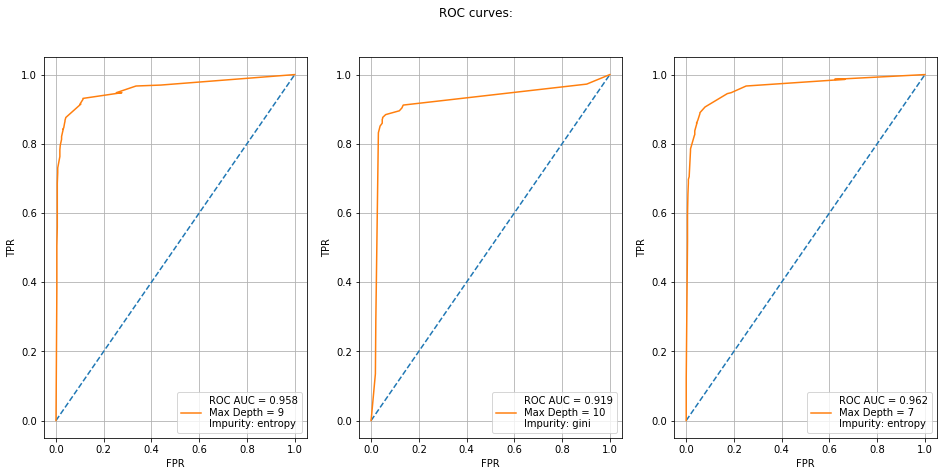

In [829]:
top_rocs(top_s, X_vs, y_vs)